In [1]:
import os
from collections import defaultdict
import pandas as pd
from math import e, log
from scipy.stats import entropy
import numpy as np
import gensim
from gensim.utils import simple_preprocess
from gensim import corpora, models
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

from nltk import tokenize
from transformers import AutoModel, AutoTokenizer

from source.Topic.Utils import *
from source.Topic.Model import *
import re

Using TensorFlow backend.


In [4]:
#meta = pd.read_csv("metadata.csv")
#meta = pd.read_csv("demo_text_chunk_0.csv", sep=";")

In [2]:
meta = pd.read_csv("kaffee_reviews.csv")
meta.drop(columns=["index"], inplace=True)

In [3]:
meta.head()

,brand,rating,review
0,GEPA Kaffee,5,Wenn ich Bohnenkaffee trinke (auf Arbeit trink...
1,GEPA Kaffee,5,Für mich ist dieser Kaffee ideal. Die Grundvor...
2,GEPA Kaffee,5,Ich persönlich bin insbesondere von dem Geschm...
3,GEPA Kaffee,5,ganz abgesehen vom geschmack legt gepa inzwisc...
4,GEPA Kaffee,5,Seit Jahren kaufe ich am liebsten den Kaffee u...


In [19]:
sentences = []
sentence_to_summary = {}
for i, body in enumerate(meta.body):
    for sentence in tokenize.sent_tokenize(body, language="german"):
        sentences.append(sentence.replace("-", " ").replace("   ", " - "))
        sentence_to_summary[sentences.__len__() - 1] = i

In [3]:
documents = meta.iloc[:, 0]
documents=documents.reset_index()
documents.drop("index", inplace = True, axis = 1)

##create pandas data frame with all abstracts, use as input corpus
documents["index"] = documents.index.values
documents.head(3)

,body,index
0,"Die Deutschen gelten als Aktienmuffel, daran ä...",0
1,Für manche Beschäftigte ist es jedes Jahr ein ...,1
2,Als sich die Thyssenkrupp-Eigner Anfang des Ja...,2


In [3]:
method = "BERT" # "LDA_BERT"
samp_size = len(meta.review)
ntopic = 10

rws = meta.review
#rws = pd.Series(sentences)
sentences, token_lists, idx_in = preprocess(rws, samp_size=samp_size)
# Define the topic model object
# tm = Topic_Model(k = 10), method = TFIDF)

Preprocessing raw texts ...
Preprocessing raw texts. Done!


In [4]:
tm = Topic_Model(k=ntopic, method=method)
# Fit the topic model by chosen method
tm.fit(sentences, token_lists)
# Evaluate using metrics
#with open("/kaggle/working/{}.file".format(tm.id), "wb") as f:
#    pickle.dump(tm, f, pickle.HIGHEST_PROTOCOL)

Clustering embeddings ...
Getting vector representations for BERT ...
Getting vector representations for BERT. Done!
Clustering embeddings. Done!


In [5]:
print('Coherence:', get_coherence(tm, token_lists, 'c_v'))
print('Silhouette Score:', get_silhouette(tm))
# visualize and save img

Coherence: 0.2979755125903355
Silhouette Score: 0.5565625


Calculating UMAP projection ...
Calculating UMAP projection. Done!
Getting wordcloud for topic 0 ...
Getting wordcloud for topic 0. Done!
Getting wordcloud for topic 1 ...
Getting wordcloud for topic 1. Done!
Getting wordcloud for topic 2 ...
Getting wordcloud for topic 2. Done!
Getting wordcloud for topic 3 ...
Getting wordcloud for topic 3. Done!
Getting wordcloud for topic 4 ...
Getting wordcloud for topic 4. Done!
Getting wordcloud for topic 5 ...
Getting wordcloud for topic 5. Done!
Getting wordcloud for topic 6 ...
Getting wordcloud for topic 6. Done!
Getting wordcloud for topic 7 ...
Getting wordcloud for topic 7. Done!
Getting wordcloud for topic 8 ...
Getting wordcloud for topic 8. Done!
Getting wordcloud for topic 9 ...
Getting wordcloud for topic 9. Done!


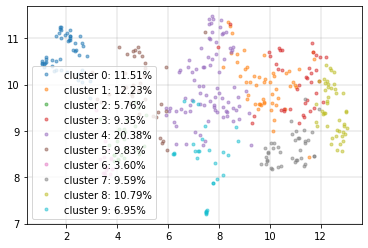

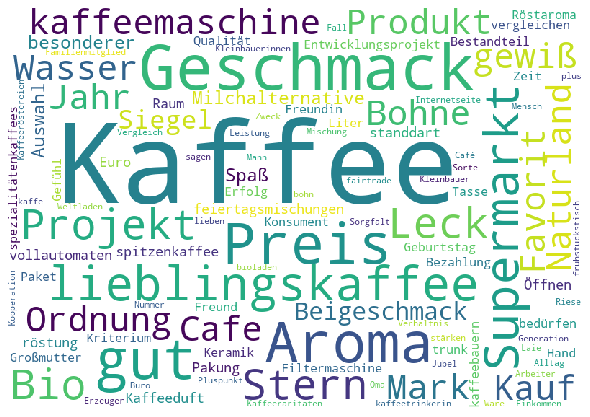

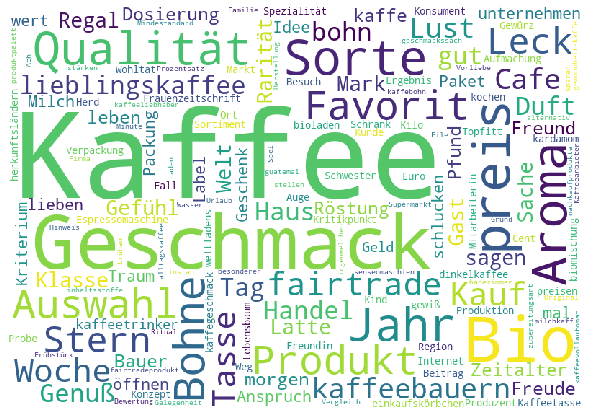

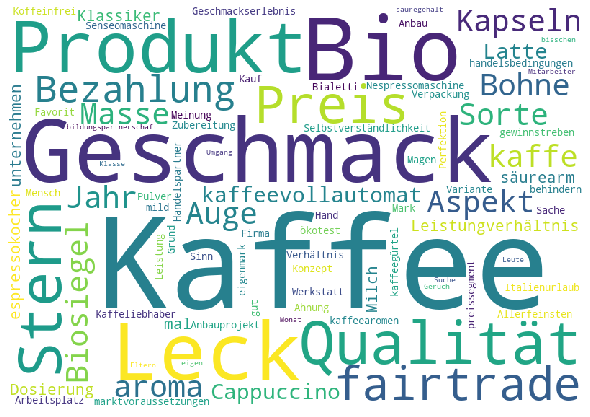

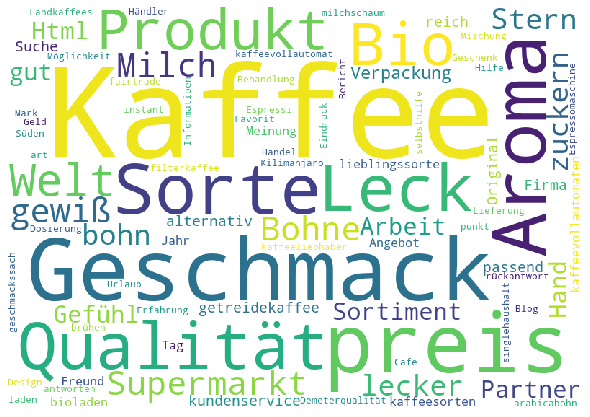

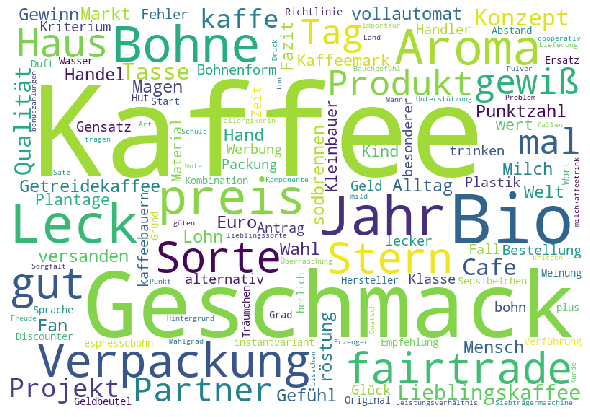

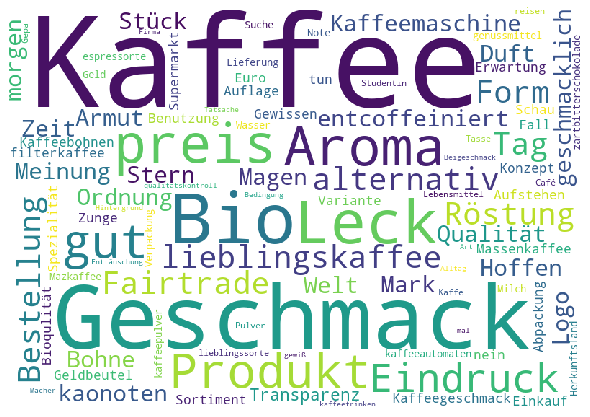

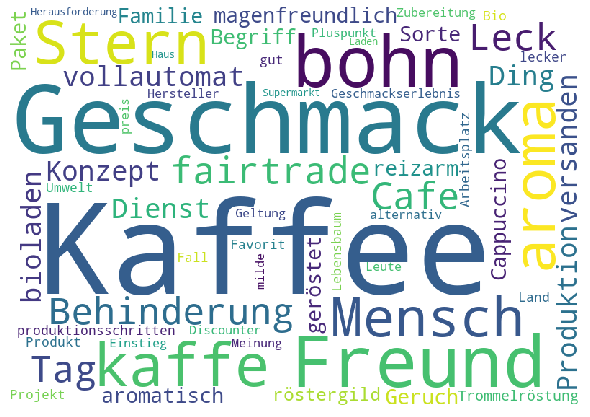

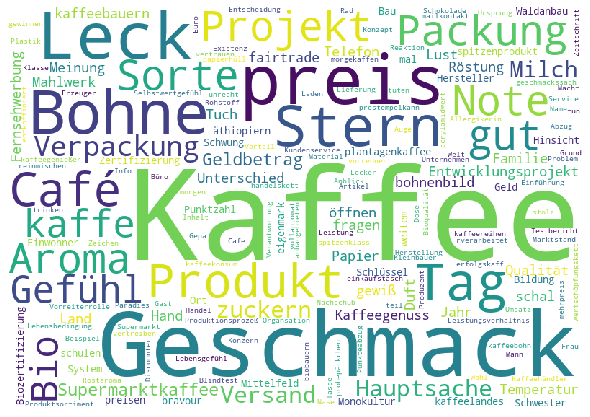

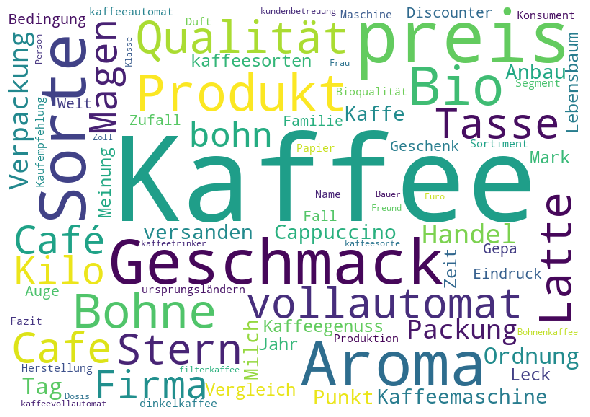

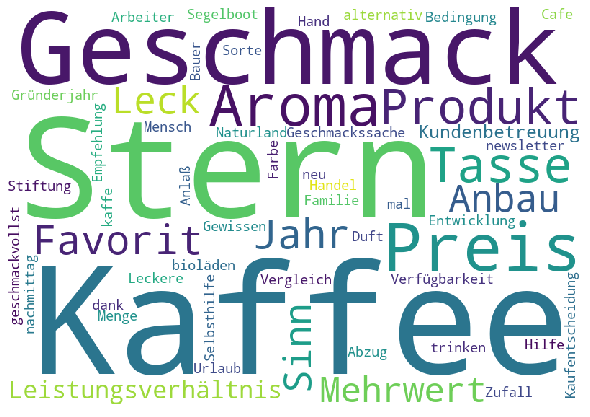

In [5]:
visualize(tm)
for i in range(tm.k):
    get_wordcloud(tm, token_lists, i)

In [6]:
clusters = [[] for _ in range(ntopic)]
for text_i, cluster in enumerate(tm.cluster_model.labels_):
    clusters[cluster].append([meta.review[idx_in[text_i]], token_lists[text_i]])

cluster_words = [np.unique(np.concatenate(np.vstack(clusters[i])[:,1]), return_counts=True) for i in range(ntopic)]

In [7]:
all_words, all_count = np.unique(np.concatenate(token_lists), return_counts=True)
entropy_words = np.empty(len(all_words))
for i, word in enumerate(all_words):
    count_per_cluster = []
    for unique, count in cluster_words:
        idx = np.where(unique == word)[0]
        if len(idx) > 0:
            count_per_cluster.append(count[idx[0]])
        else:
            count_per_cluster.append(0)
    entropy_words[i] = entropy(count_per_cluster) / np.log(len(count_per_cluster))

In [8]:
for i in range(len(cluster_words)):
    entropy_cluster = np.empty(len(cluster_words[i][0]))
    for j, word in enumerate(cluster_words[i][0]):
        entropy_cluster[j] = entropy_words[np.where(all_words == word)[0][0]]
    cluster_words[i] = [cluster_words[i][0], cluster_words[i][1], entropy_cluster]

In [9]:
n = 4
for words, word_count, entropy_word in cluster_words:
    #ind = np.argpartition(entropy_word, -4)[-4:]
    ind = entropy_word.argsort()[:n][::-1]
    print(words[ind])

['Großmutter' 'Generation' 'Milchalternative' 'Öffnen']
['Körper' 'Label' 'badezimmer' 'Ach']
['Leistungverhältnis' 'Koffeinfrei' 'Klassiker' 'Ahnung']
['Intencion' 'Informatioen' 'Html' 'Abstrich']
['bohnenform' 'bonuszahlungen' 'Kontakt' 'Abstand']
['Logo' 'Kaffeegeschmack' 'Kaffeebohnen' 'Abpackung']
['Umwelt' 'geröstet' 'aromatisch' 'Geltung']
['äthiopiern' 'Rad' 'Reaktion' 'kaffeelandes']
['Vielfalt' 'Verwandtschaft' 'Verträglichkeit' 'Abendessen']
['Stiftung' 'dank' 'bioläden' 'Geschmackssache']


In [10]:
n = 4
for words, word_count, entropy_word in cluster_words:
    #ind = np.argpartition(entropy_word, -4)[-4:]
    foo = word_count / entropy_word
    ind = foo.argsort()[:n][::-1]
    print(words[ind])

['Tasse' 'Qualität' 'fairtrade' 'kaffe']
['bioladen' 'gewiß' 'Konzept' 'alternativ']
['Meinung' 'preis' 'Mark' 'gut']
['fairtrade' 'Mark' 'Preis' 'kaffe']
['Duft' 'Meinung' 'Mark' 'Preis']
['fairtrade' 'Mark' 'Preis' 'Stern']
['preis' 'gut' 'Aroma' 'Produkt']
['mal' 'Tasse' 'Cafe' 'Mark']
['alternativ' 'fairtrade' 'gut' 'kaffe']
['alternativ' 'Cafe' 'preis' 'kaffe']


In [11]:
print(entropy_words[np.where(all_words == "Stern")[0][0]])

0.8537698567913365


In [11]:
distance_centroid = tm.cluster_model.transform(tm.vec[tm.method])

In [15]:
sample_cluster = 8
sample_count = 3

ind = np.argsort(distance_centroid[:, sample_cluster])[::][:sample_count]
for i in ind:
    print(meta.review[idx_in[i]])

Ich kaufe immer den gemahlenen Espresso (ich besitze leider keine Kaffeemühle) von Mount Hagen und bin seit der ersten Tasse vollkommen überzeugt. Zubereitet in einer italienischen Moka Express ist der Espresso sowohl pur als auch mit Milch ein Genuss. Das Aroma ist kräftig und sanft zugleich, ein wenig schokoladig und nicht bitter, alles in allem ein abgerundetes Geschmackserlebnis. Ein i-Tüpfelchen wäre natürlich noch eine nachhaltigere Verpackung, aber auch ohne diese vergebe ich 5 Sterne für diesen Kaffee.
Kaffee ist einer der wenigen Dinge die mich morgens zum aufstehen bewegen können. Mount Hagen Arabica Kaffee ganze Bohne hat mich dabei voll und ganz überzeugt. das Aroma ist toll, nicht verbrannt aber sehr wenig säure, das mag ich. Preislich liegt er in der unteren Mittelklasse vergleichbarer Kaffees. Das stört ihn aber in seiner Qualität kein bisschen. Ich kann ihn sehr empfehlen.
Wenn ich Bohnenkaffee trinke (auf Arbeit trinke ich wegen der Kapselmaschine nur Kaffee aus Granul

In [16]:
all_words

array(['Abendessen', 'Abpackung', 'Abstand', 'Abstrich', 'Abwechlung',
       'Abwechslung', 'Abzug', 'Ach', 'Achtung', 'Adresse', 'Ahnung',
       'Allerfeinsten', 'Allergikerin', 'Alltag', 'Aluminium', 'Anbau',
       'Anbaugebiet', 'Anbauprojekt', 'Anbieter', 'Anblick', 'Anfang',
       'Angebot', 'Anlaß', 'Anspruch', 'Anteil', 'Antrag', 'Arbeit',
       'Arbeiter', 'Arbeitsbedingung', 'Arbeitsplatz', 'Armut', 'Aroma',
       'Art', 'Artikel', 'Aspekt', 'Atmosphäre', 'Auflage', 'Aufmachung',
       'Aufstehen', 'Auge', 'Ausbeutung', 'Auskunft', 'Aussage',
       'Auswahl', 'Automat', 'Bafög', 'Bau', 'Bauchgefühl', 'Bauer',
       'Bedingung', 'Begriff', 'Behandlung', 'Behinderung',
       'Beigeschmack', 'Beispiel', 'Beitrag', 'Benutzung', 'Bereich',
       'Bericht', 'Berührung', 'Bestandteil', 'Bestellung', 'Besuch',
       'Besucher', 'Bewertung', 'Bezahlung', 'Bialetti', 'Bildung', 'Bio',
       'Bioqualität', 'Bioqulität', 'Biosiegel', 'Biozertifizierung',
       'Bitterkeit', 

In [7]:
tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-german-cased")
model = AutoModel.from_pretrained("dbmdz/bert-base-german-cased")

In [9]:
foo = "Ich nutze von REWE Bio Röstkaffee Fairtrade die Kaffeepads für meine Senseomaschiene. Ich habe schon einige Biokaffees ausprobiert und muss sagen, dass mir der REWE Bio Röstkaffee Fairtrade am Besten schmeckt. Das Preis/Leistungsverhältnis ist super, wenn man bedenkt, wie teuer die original Senseopads sind (ohne Bio und Fairtradesiegel!)."
#word_tokenize(foo, language="german")
tokenizer.tokenize(foo)

['Ich',
 'nutz',
 '##e',
 'von',
 'RE',
 '##W',
 '##E',
 'Bio',
 'Rö',
 '##st',
 '##ka',
 '##ffe',
 '##e',
 'Fair',
 '##tra',
 '##de',
 'die',
 'Kaffee',
 '##pa',
 '##ds',
 'für',
 'meine',
 'Sens',
 '##eo',
 '##mas',
 '##chi',
 '##ene',
 '.',
 'Ich',
 'habe',
 'schon',
 'einige',
 'Bio',
 '##ka',
 '##ffe',
 '##es',
 'aus',
 '##pro',
 '##biert',
 'und',
 'muss',
 'sagen',
 ',',
 'dass',
 'mir',
 'der',
 'RE',
 '##W',
 '##E',
 'Bio',
 'Rö',
 '##st',
 '##ka',
 '##ffe',
 '##e',
 'Fair',
 '##tra',
 '##de',
 'am',
 'Besten',
 'schmeckt',
 '.',
 'Das',
 'Preis',
 '/',
 'Leistungs',
 '##verhältnis',
 'ist',
 'super',
 ',',
 'wenn',
 'man',
 'bede',
 '##nk',
 '##t',
 ',',
 'wie',
 'teuer',
 'die',
 'original',
 'Sens',
 '##eo',
 '##pa',
 '##ds',
 'sind',
 '(',
 'ohne',
 'Bio',
 'und',
 'Fair',
 '##tra',
 '##des',
 '##iegel',
 '!',
 ')',
 '.']

In [15]:
tokenizer.tokenize("Dachdeckerarbeiten")

['Dach', '##decker', '##arbeiten']

In [68]:
foo = meta.iloc[0].review

def split_sentences(doc, language="german"):
    sentences = []
    for sentence in tokenize.sent_tokenize(doc, language=language):
        sentences.append(sentence)
    return sentences

def stem(doc, lang="german"):
    tagger = ht.HanoverTagger('morphmodel_ger.pgz')
    result = []
    for sentence in doc:
        stem_sentence = tokenize.word_tokenize(sentence)
        result.append([lemma for (word, lemma, pos) in tagger.tag_sent(stem_sentence)])
    return result

def word_count(stem_sentences):
    stem_sentences = np.concatenate(stem_sentences)
    stem_sentences = stem_sentences[(stem_sentences != "--") & (stem_sentences != '“') & (stem_sentences != '„')]
    stem_sentences, counts = np.unique(stem_sentences, return_counts=True)
    return stem_sentences, counts

def frequency(word, sentence):
    unique, counts = np.unique(sentence, return_counts=True)
    index = np.where(unique == word)[0]
    if len(index) == 0:
        return 0
    return counts[index[0]] / len(sentence)

def matrix(doc):
    sentences = split_sentences(doc)
    stem_sentences = stem(sentences)
    unique_words, counts = word_count(stem_sentences)
    mat = np.empty((len(sentences), len(unique_words)))
    for i in range(len(sentences)):
        for j in range(len(unique_words)):
            if unique_words[j] in stem_sentences[i]:
                g_t_ji = 0
                for sentence in stem_sentences:
                    t_ji = frequency(unique_words[j], sentence)
                    g_ji = counts[j]
                    p_ji = t_ji / g_ji
                    if p_ji != 0:
                        g_t_ji += p_ji * np.log(p_ji) / np.log(len(sentences))
                g_t_ji = 1 - g_t_ji
                mat[i][j] = g_t_ji
            else:
                mat[i][j] = 0
    return mat

#split_sentences(foo)
#stem(split_sentences(foo))
#word_count(stem(split_sentences(foo)))
mat = matrix(foo)
u, s , vh = np.linalg.svd(mat, full_matrices=True)
vh
u
s

array([6.41646989, 4.85873423, 4.42194409, 4.3134068 , 4.09802056,
       3.76898427])

In [ ]:
# https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270
# https://www.youtube.com/watch?v=OR0wfP2FD3c
